In [1]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="15s", chunk_memory = "500M", progress_bar=True)


SpikeInterface version: 0.103.0


In [2]:
# Path setup
# basepath = "/local/workdir/ys2375/data/ayadataB3/data/AutoMaze/HP18/hp18_day86_20250708"
basepath = 'T:\\data\\AutoMaze\\RM010\\RM010_day43_20250925'
base_dir = Path(basepath)

# Copy and rename XML file to basepath
src_xml = base_dir.parent / "amplifier.xml"
dest_xml = base_dir / (base_dir.name + ".xml")
if src_xml.exists() and not dest_xml.exists():
    shutil.copy2(src_xml, dest_xml)
    print(f"Copied and renamed: {src_xml} -> {dest_xml}")
else:
    print(f"XML file already exists at destination")

xmlPath = dest_xml
print(f"XML path: {xmlPath}")

# Find recording files
dataPath = sorted(glob.glob(str(base_dir / "*/amplifier.dat")), key=extract_datetime)
display(dataPath)

# Output directory for sorting results
outputDir = Path(os.getcwd()) / "sorting_temp" / base_dir.name
outputDir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {outputDir}")


XML file already exists at destination
XML path: T:\data\AutoMaze\RM010\RM010_day43_20250925\RM010_day43_20250925.xml


['T:\\data\\AutoMaze\\RM010\\RM010_day43_20250925\\RM010_presleep_250925_094220\\amplifier.dat',
 'T:\\data\\AutoMaze\\RM010\\RM010_day43_20250925\\RM010_ProbSwitching_session01_250925_114407\\amplifier.dat',
 'T:\\data\\AutoMaze\\RM010\\RM010_day43_20250925\\RM010_postsleep_250925_124918\\amplifier.dat']

Output directory: d:\PreprocessPipeline\sorting_temp\RM010_day43_20250925


## Mapping channel

In [3]:
probe_assignments = [
    {'type': 'double_sided', 'groups': [0, 1, 2, 3], 'x_offset': 0},
    {'type': 'double_sided', 'groups': [4, 5, 6, 7], 'x_offset': 1000},
    {'type': 'double_sided', 'groups': [8, 9, 10, 11], 'x_offset': 2000}
]

# probe_assignments = [
#     {'type': 'double_sided', 'groups': [0, 1, 2, 3, 4, 5, 6, 7], 'x_offset': 0},
# ]

chanMapPath = create_channel_map(
    basepath=basepath,
    outputDir = outputDir,
    probe_assignments=probe_assignments,
    reject_channels=[]
)
print(f"Channel map file path: {chanMapPath}")


Reading XML from: T:\data\AutoMaze\RM010\RM010_day43_20250925\RM010_day43_20250925.xml
Found 12 anatomical groups (XML document order).
Default electrode layout: staggered
Processing Probe 1: Type=double_sided, Groups=[0, 1, 2, 3], X_Offset=0
Processing Probe 2: Type=double_sided, Groups=[4, 5, 6, 7], X_Offset=1000
Processing Probe 3: Type=double_sided, Groups=[8, 9, 10, 11], X_Offset=2000
Successfully saved chanMap.mat to d:\PreprocessPipeline\sorting_temp\RM010_day43_20250925\chanMap.mat
Channel map file path: d:\PreprocessPipeline\sorting_temp\RM010_day43_20250925\chanMap.mat


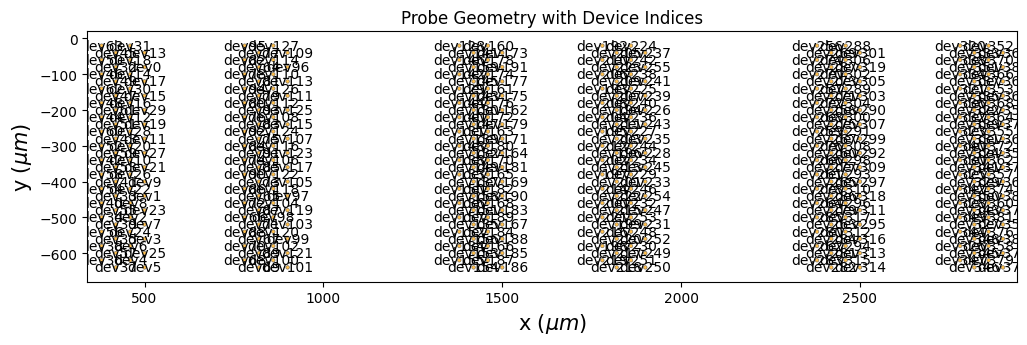

Bad channel IDs (0-based): [135 136 137 138 139 140 141 142 143 144 145 146 147 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287]


In [4]:
chanMapmat = loadmat(chanMapPath)
x = chanMapmat['xcoords'].flatten()
y = chanMapmat['ycoords'].flatten()
shank_ids = chanMapmat['kcoords'].flatten()
# Note: if 'probe_ids' is missing from an old file, default to 1 for all channels
probe_ids = chanMapmat.get('probe_ids', np.ones_like(x)).flatten()
device_ch_inds = chanMapmat['chanMap'].flatten()-1
connected = chanMapmat['connected'].flatten()
bad_ch_ids = np.where(connected == 0)[0]

probegroup = ProbeGroup()
# Filter out p_id=0 (unassigned channels)
unique_probes = [p for p in np.unique(probe_ids) if p > 0]

for p_id in unique_probes:
    mask = (probe_ids == p_id)
    # Filter the data for this probe
    p_x = x[mask]
    p_y = y[mask]
    p_shank_ids = shank_ids[mask]
    p_device_ch_inds = device_ch_inds[mask]
    p_connected = connected[mask]
    
    # Create the Probe object
    probe = Probe(ndim=2, si_units='um')
    probe.set_contacts(
        positions=np.column_stack((p_x, p_y)),
        shapes='circle',
        shape_params={'radius': 5},
        shank_ids=p_shank_ids
    )
    probe.set_device_channel_indices(p_device_ch_inds)
    # Optional: you can manually flag bad contacts if you want them styled differently in ProbeInterface
    # probe.set_contact_ids([f"ch{int(i)}" for i in p_device_ch_inds]) 
    
    probegroup.add_probe(probe)

fig, ax = plt.subplots(figsize=(12, 8)) # Increased height for better visualization of long probes
plot_probegroup(probegroup, with_contact_id=False, with_device_index=True, ax=ax)
plt.title("Probe Geometry with Device Indices")
plt.show()
print(f"Bad channel IDs (0-based): {bad_ch_ids}")

In [5]:
# chanMapPath = glob.glob(basepath + '/chanMap.mat')[0]
# chanMapmat_correct = loadmat(chanMapPath)
# x = chanMapmat_correct['xcoords'].flatten()
# y = chanMapmat_correct['ycoords'].flatten()
# coords = np.column_stack((x, y))
# shank_ids = chanMapmat_correct['kcoords'].flatten()
# device_ch_inds = chanMapmat_correct['chanMap'].flatten() - 1
# bad_ch_ids = np.where(chanMapmat_correct['connected'][:,0]==0)[0]
# print(bad_ch_ids)

# probe = Probe(ndim=2, si_units='um')
# probe.set_contacts(
#     positions=coords,
#     shapes='circle',
#     shape_params={'radius': 5},
#     shank_ids=shank_ids
# )
# probe.set_device_channel_indices(device_ch_inds)

# fig, ax = plt.subplots(figsize=(12,4)) 
# plot_probe(probe, with_contact_id=True, with_device_index=True, ax=ax)

## Concatenate .dat

In [6]:
# Sampling frequency and channel count
fs = get_sampling_rate(xmlPath)
num_channels = len(device_ch_inds)
recording_list = []

# Read and load each binary recording file
for i in range(len(dataPath)):
    recording_ = se.read_binary(
        dataPath[i],
        sampling_frequency=fs,
        dtype='int16',
        num_channels=num_channels,
        gain_to_uV=0.195,
        offset_to_uV=0
    )
    print(dataPath[i])
    recording_list.append(recording_)

# Concatenate all recordings into single recording object
recording = si.concatenate_recordings(recording_list)


T:\data\AutoMaze\RM010\RM010_day43_20250925\RM010_presleep_250925_094220\amplifier.dat
T:\data\AutoMaze\RM010\RM010_day43_20250925\RM010_ProbSwitching_session01_250925_114407\amplifier.dat
T:\data\AutoMaze\RM010\RM010_day43_20250925\RM010_postsleep_250925_124918\amplifier.dat


In [7]:
recording

ConcatenateSegmentRecording: 384 channels - 20.0kHz - 1 segments - 298,090,752 samples 
                             14,904.54s (4.14 hours) - int16 dtype - 213.21 GiB

In [8]:
# Extract the last directory name and save recording using write_binary_recording
file_name = Path(basepath).name + '.dat'
final_dat_path = Path(outputDir) / file_name

# Write concatenated binary recording with desired filename
if not final_dat_path.exists():
    si.write_binary_recording(
        recording,
        file_paths=str(final_dat_path),
        add_file_extension=False,
        verbose=True,
        **job_kwargs
    )
    print(f"Saved to: {final_dat_path}")
else:
    print(f"File already exists: {final_dat_path}")

File already exists: d:\PreprocessPipeline\sorting_temp\RM010_day43_20250925\RM010_day43_20250925.dat


## Preprocessing
### Set probe
### Remove bad channel
### Bandpass filter (500 - 8000 Hz)
### Common median filter 
### Artifact removal

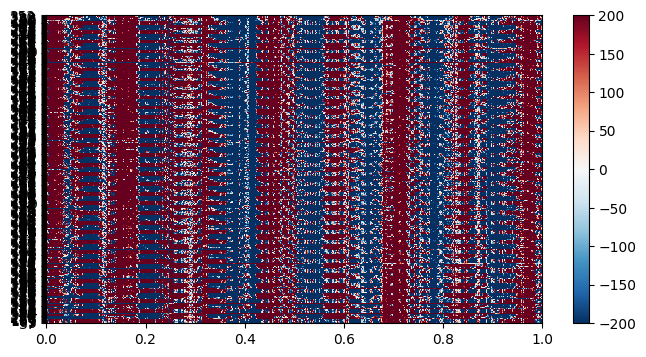

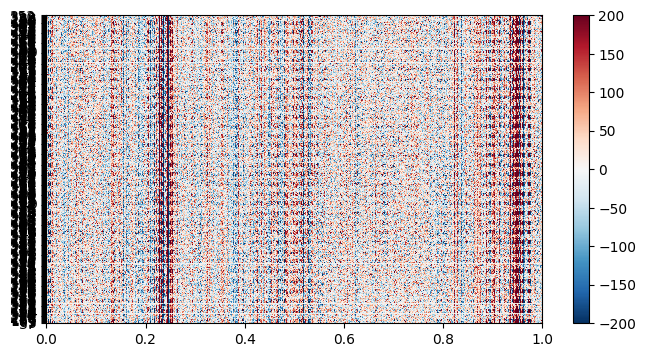

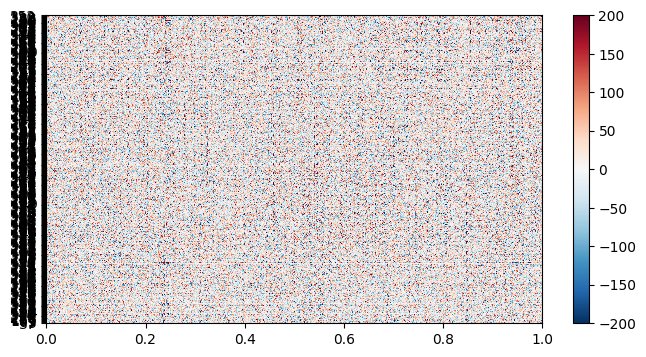

In [36]:
# Set probe and remove bad channels
# Use set_probegroup for ProbeGroup objects
# recording_raw = recording.set_probegroup(probe, group_mode='by_shank')
recording = se.BinaryRecordingExtractor(str(final_dat_path), sampling_frequency=fs, dtype='int16', num_channels=num_channels)
recording_raw = recording.set_probegroup(probegroup, group_mode='by_probe')
recording_raw = recording_raw.remove_channels(remove_channel_ids=bad_ch_ids)

# Plot parameters
tmin = 0
twind = 1
segment_index = 0

# Plot raw traces
sw.plot_traces(
    recording_raw,
    channel_ids=recording_raw.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply bandpass filter (500-8000 Hz)
recording_f = spre.bandpass_filter(recording_raw, freq_min=500, freq_max=8000)
sw.plot_traces(
    recording_f,
    channel_ids=recording_f.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)

# Apply common median reference (local)
recording_cmr = spre.common_reference(
    recording_f,
    reference='local',
    local_radius=[50, 200],
    operator='median'
)
sw.plot_traces(
    recording_cmr,
    channel_ids=recording_cmr.get_channel_ids(),
    order_channel_by_depth=True,
    show_channel_ids=True,
    time_range=[tmin, tmin + twind],
    segment_index=segment_index,
    color_groups=False,
    figsize=(8, 4)
)


## (Optional) Remove artifacts

In [37]:
from utils.artifact_removal import detect_high_amplitude_artifacts, remove_artifacts, plot_traces_around_artifact

In [38]:
# digitalinPath = sorted(glob.glob(str(base_dir / "*/digitalin.dat")), key=extract_datetime)
# display(digitalinPath)

# digitalin_list = []
# for p in digitalinPath:
#     d = np.fromfile(p, dtype=np.uint16)
#     digitalin_list.append(d)

# digitalin_all = np.concatenate(digitalin_list)
# print(f"Total digitalin length: {len(digitalin_all)}")

In [39]:
# # Detect active TTL channels from digitalin_all
# active_channels = []
# for i in range(16):
#     if np.any(digitalin_all & (1 << i)):
#         active_channels.append(i)

# print(f"Active digital channels (0-15): {active_channels}")
# # Extract TTL timing for a specific channel to be used as artifact_ttl
# # Change 'target_ch' to the channel number you want to use (0-15)
# target_ch = 7 

# ch_data = (digitalin_all & (1 << target_ch)) > 0
# artifact_ttl = list(np.where(np.diff(ch_data.astype(int)) == 1)[0])

# print(f"Extracted {len(artifact_ttl)} TTL pulses from channel {target_ch}")
# print(f"artifact_ttl: {artifact_ttl[:10]}...")


In [40]:
# recording_clean, info = remove_artifacts(
#     recording_in=recording_cmr,              
#     artifact_per_group=artifact_ttl,
#     by_group = True,   
#     ms_before=1,
#     ms_after=1,
#     mode="cubic",
# )

In [41]:
# plot_traces_around_artifact(
#     recording_before=recording_cmr,
#     recording_after=recording_clean,
#     ttl_times=artifact_ttl,  
#     before_ms=10.0,
#     after_ms=10.0,
#     units="frames",
#     segment_index=0,
#     channel_ids=recording_cmr.get_channel_ids(), 
#     figsize=(8, 3),  
#     n_max=10,                                     
# )


In [42]:
# triggers = detect_high_amplitude_artifacts(
#     recording_clean,
#     by_group=False,
#     estimate_windows=50,       
#     threshold_sigma=10.0,      
#     chunk_s=100,               
#     dead_time_ms=5.0,        
#     n_jobs=-1                  
# )

In [43]:
# recording_clean, info = remove_artifacts(
#     recording_in=recording_clean,              
#     artifact_per_group=triggers,
#     by_group = False,   
#     ms_before=1,
#     ms_after=1,
#     mode="cubic",
# )

In [44]:
# plot_traces_around_artifact(
#     recording_before=recording_cmr,
#     recording_after=recording_clean,
#     ttl_times=triggers[0],  
#     # before_ms=10.0,
#     # after_ms=10.0,
#     before_ms=10.0,
#     after_ms=10.0,
#     units="frames",
#     segment_index=0,
#     channel_ids=recording_cmr.get_channel_ids(), 
#     figsize=(8, 3),  
#     n_max=10,                                     
# )


## Spike Sorting

In [45]:
params = ss.get_default_sorter_params('kilosort')
params

{'detect_threshold': 6,
 'car': True,
 'useGPU': True,
 'freq_min': 300,
 'freq_max': 6000,
 'ntbuff': 64,
 'Nfilt': None,
 'NT': None,
 'wave_length': 61,
 'delete_tmp_files': ('matlab_files',),
 'delete_recording_dat': False,
 'parfor': 0.0,
 'nNeighPC': None,
 'nNeigh': 16.0,
 'whitening': 'full',
 'nSkipCov': 1.0,
 'whiteningRange': 32.0,
 'Nrank': 3.0,
 'nfullpasses': 6.0,
 'maxFR': 20000,
 'Th': [4.0, 10.0, 10.0],
 'lam': [5.0, 5.0, 5.0],
 'nannealpasses': 4.0,
 'momentum': [0.05, 0.0025],
 'shuffle_clusters': 1.0,
 'mergeT': 0.1,
 'splitT': 0.1,
 'initialize': 'fromData',
 'loc_range': [3.0, 1.0],
 'long_range': [30.0, 6.0],
 'maskMaxChannels': 5.0,
 'crit': 0.65,
 'nFiltMax': 10000.0,
 'fracse': 0.1,
 'epu': inf,
 'ForceMaxRAMforDat': 20000000000.0,
 'pool_engine': 'process',
 'n_jobs': 1,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_worker': 1}

In [46]:
params['useGPU'] = True               # ops.GPU = 1
params['freq_min'] = 500              # ops.fshigh = 500
params['freq_max'] = 8000             # ops.fslow = 8000
params['ntbuff'] = 64                 # ops.ntbuff = 64
params['parfor'] = True               # ops.parfor = 1
params['nNeighPC'] = 16               # ops.nNeighPC = 16
params['nNeigh'] = 16                 # ops.nNeigh = 16
params['whitening'] = 'full'          # ops.whitening = 'full'
params['nSkipCov'] = 1                # ops.nSkipCov = 1
params['whiteningRange'] = 64         # ops.whiteningRange = 64 (min([64 ...]))
params['Nrank'] = 3                   # ops.Nrank = 3
params['nfullpasses'] = 6             # ops.nfullpasses = 6
params['maxFR'] = 40000               # ops.maxFR = 40000
params['Th'] = [6.0, 10.0, 10.0]      # ops.Th = [6 10 10]
params['lam'] = [12.0, 40.0, 40.0]    # ops.lam = [12 40 40]
params['nannealpasses'] = 4           # ops.nannealpasses = 4
params['momentum'] = [0.05, 0.00125]  # ops.momentum = 1./[20 800]
params['shuffle_clusters'] = True     # ops.shuffle_clusters = 1
params['mergeT'] = 0.1                # ops.mergeT = .1
params['splitT'] = 0.1                # ops.splitT = .1
params['initialize'] = 'fromData'     # ops.initialize = 'fromData'
params['loc_range'] = [3, 1]          # ops.loc_range = [3 1]
params['long_range'] = [30, 6]        # ops.long_range = [30 6]
params['maskMaxChannels'] = 8         # ops.maskMaxChannels = 8
params['crit'] = 0.65                 # ops.crit = .65
params['nFiltMax'] = 80000            # ops.nFiltMax = 80000
params['fracse'] = 0.1                # ops.fracse = 0.1
params['epu'] = float('inf')          # ops.epu = Inf
params['ForceMaxRAMforDat'] = 15000000000.0 # ops.ForceMaxRAMforDat = 15000000000
params['detect_threshold'] = 4

In [ ]:
%%time
# timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
# output_folder = Path(outputDir) / f"Kilosort4_{timestamp}"
output_folder = Path(outputDir) / f"Kilosort1"
sorting = ss.run_sorter(
    sorter_name="kilosort",
    recording=recording_cmr,
    folder=output_folder,
    with_output=True,
    remove_existing_folder = True,
    docker_image="spikeinterface/kilosort-compiled-base:latest",
    **params
)

## Postprocessing
### Remove duplicated spikes from same cluster
### Remove redundant clusters

In [ ]:
output_folder = Path(outputDir) / f"Kilosort1"
sorting = se.read_phy(Path(output_folder) / 'sorter_output')

In [ ]:
# Remove duplicated spikes within 0.5ms of same cluster
sorting_removed_duplicates = scur.remove_duplicated_spikes(sorting, censored_period_ms=0.5)

# Create sorting analyzer for quality assessment
sa_tmp = si.create_sorting_analyzer(
    sorting_removed_duplicates,
    recording_cmr,
    format="memory",
    sparse=False
)

# Remove redundant units (putative duplicates)
sorting_clean, redundancy_info = scur.remove_redundant_units(
    sa_tmp, 
    align=False, 
    duplicate_threshold=0.5,
    remove_strategy="max_spikes",
    extra_outputs=True,
)
print(f"Removed {len(redundancy_info)} redundant cluster combinations.")

Removed 297 redundant cluster combinations.


### Calculare unit features

In [ ]:
# Create or load sorting analyzer with computed features
analyzer_folder = Path(Path(output_folder) / 'analyzer_cache')

if analyzer_folder.exists():
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)
    print("Loaded existing analyzer from disk.")
else:
    # Create new analyzer
    analyzer = si.create_sorting_analyzer(
        sorting=sorting_clean,
        recording=recording_cmr,
        format="binary_folder",   
        folder=analyzer_folder,
        overwrite=True,
        **job_kwargs,
    )

    # Compute all required features
    analyzer.compute(
        {
            "random_spikes": {"method": "all"}, 
            
            "waveforms": {},
            "templates": {},          
            "noise_levels": {},
            "spike_amplitudes": {},
            "principal_components": {"n_components": 5, "mode": "by_channel_local"}, 
            "template_metrics": {},       
            "template_similarity": {},    
            "correlograms": {},
            "spike_locations": {},
            "unit_locations": {},
        },
        **job_kwargs,  
    )
    analyzer = si.load_sorting_analyzer(folder=analyzer_folder)

estimate_sparsity (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s]

compute_waveforms (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/89 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/89 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s…

### Merge clusters

In [ ]:
# Define merge criteria for clustering
steps_params = {
    "num_spikes": {           
        "min_spikes": 100,    
    },
    "correlogram": {
        "corr_diff_thresh": 0.25,
    },
    "template_similarity": {
        "template_diff_thresh": 0.25
    }
}

# Compute merge candidates based on similarity and correlograms
print("Computing merge candidates...")
merge_groups = scur.compute_merge_unit_groups(
    analyzer,                   
    preset="similarity_correlograms", 
    resolve_graph=True,               
    steps_params=steps_params    
)
print(f"Found {len(merge_groups)} groups to merge.")

Computing merge candidates...
Found 0 groups to merge.


In [ ]:
for i in range(len(merge_groups)):
    sw.plot_crosscorrelograms(
        sorting_analyzer_or_sorting=analyzer,
        unit_ids=merge_groups[i],            
        bin_ms=1,
        window_ms=25.0,
        figsize=(4, 3)
    )

In [ ]:
# Check which unit groups can be safely merged
mergeable = analyzer.are_units_mergeable(
    merge_unit_groups=merge_groups,
    merging_mode="soft",
    sparsity_overlap=0.5
)

# Filter to only safely mergeable groups
merge_groups = [g for g, ok in mergeable.items() if ok]
nonmerge_groups = [g for g, ok in mergeable.items() if not ok]

# Create analyzer with merged units
analyzer_merged_folder = Path(output_folder) / "analyzer_cache_merged"
if analyzer_merged_folder.exists():
    try:
        shutil.rmtree(analyzer_merged_folder)
    except:
        pass

if len(merge_groups)!=0:
    analyzer_merged = analyzer.merge_units(
        merge_unit_groups=merge_groups,
        merging_mode='soft', 
        censor_ms=0.5, 
        sparsity_overlap=0.5,
        return_new_unit_ids=False, 
        format="binary_folder", 
        folder=analyzer_merged_folder,
        overwrite=True,       
        **job_kwargs     
)
    
else:
    analyzer_merged = analyzer
    print("No units to merge.")

No units to merge.


### Split deviate waveforms

In [ ]:
from utils.unit_split import autosplit_outliers_pca

In [ ]:
sorting_split = autosplit_outliers_pca(
    analyzer_merged,
    # ---- distance (Mahalanobis) gate ----
    contamination=0.05,
    threshold_mode="calibrated_chi2",
    min_clean_frac=0.9,
    relax_factor=0.5,
    # ---- waveform similarity (Rescue) ----
    use_waveform_gate=True,        
    wf_threshold=0.2,          
    wf_cand_max=None,            
    wf_ms_before=1.0,            
    wf_ms_after=2.0,             
    wf_n_chans=10,               
    wf_center="demean", 
    squeeze_all_outlier_to_new=True,
    return_details=False,
    verbose=True,
         
)


unit 0 (1098 spikes) -> split to unit 1 (8 spikes)
unit 2 keep all
unit 3 keep all
unit 3: keep all (30 spikes) -> unit 4 (small/no-pca)
unit 4: keep all (33 spikes) -> unit 5 (small/no-pca)
unit 5: keep all (29 spikes) -> unit 6 (small/no-pca)
unit 6: keep all (42 spikes) -> unit 7 (small/no-pca)
unit 8 keep all
unit 9 keep all
unit 10 keep all
unit 11 keep all
unit 12 (4527 spikes) -> split to unit 13 (98 spikes)
unit 13: keep all (47 spikes) -> unit 14 (small/no-pca)
unit 15 keep all
unit 16 (1106 spikes) -> split to unit 17 (28 spikes)
unit 18 (29494 spikes) -> split to unit 19 (495 spikes)
unit 20 keep all
unit 21 keep all
unit 22 keep all
unit 23 (2021 spikes) -> split to unit 24 (49 spikes)
unit 25 keep all
unit 26 keep all
unit 27 keep all
unit 32: keep all (22 spikes) -> unit 28 (small/no-pca)
unit 29 keep all
unit 34: keep all (42 spikes) -> unit 30 (small/no-pca)
unit 31 (506 spikes) -> split to unit 32 (4 spikes)
unit 33 keep all
unit 38: keep all (44 spikes) -> unit 34 (sm

In [ ]:

analyzer_split = si.create_sorting_analyzer(
    sorting=sorting_split,
    recording=recording_cmr,
    format="memory",   
    folder=analyzer_folder,
    overwrite=True,
    **job_kwargs,
)

# Compute all required features
analyzer_split.compute(
    {
        "random_spikes": {"method": "all"}, 
        "waveforms": {},
        "templates": {},          
        "noise_levels": {},
        "spike_amplitudes": {},
        "principal_components": {"n_components": 5, "mode": "by_channel_local"},
        "template_metrics": {},       
        "template_similarity": {},    
        "correlograms": {},
        "spike_locations": {},
        "unit_locations": {},
    },
    **job_kwargs,  
)


estimate_sparsity (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s]

compute_waveforms (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/136 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/136 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s…

### Calcurate quality metrics and export for manual curation

In [ ]:
# Get default quality metric parameters
qm_params = sqm.get_default_qm_params()

# Compute quality metrics for all units
metrics_df = sqm.compute_quality_metrics(
    analyzer_split,
    metric_names=['isi_violation', 'presence_ratio', 'snr', 'amplitude_median'],
    metric_params=qm_params,
    skip_pc_metrics=True,  # PCs are computed above
    n_jobs=n_jobs,
    progress_bar=True
)

In [ ]:
# Export sorting results to Phy format for manual curation
# phydir2 = basepath + "/kilosort4_postprocess"
phydir2 = Path(output_folder) / "Postprocessed"
export_to_phy(
    sorting_analyzer=analyzer_split,
    output_folder=phydir2,
    compute_pc_features=True,  
    compute_amplitudes=True,    
    copy_binary=False,           
    remove_if_exists=True,
    template_mode='average',
    add_quality_metrics=True,
    add_template_metrics=True,
    dtype=None,
    use_relative_path=True,
    verbose=True,
    **job_kwargs
)

# Fix params.py for Phy
params_file = Path(phydir2) / "params.py"

with open(params_file, 'r') as f:
    content = f.read()

# 1. Set dat_path to concatenated binary file
# Fix: convert Path object to string for concatenation or use / operator with string conversion
dat_files = glob.glob(str(outputDir / "*.dat"))
if dat_files:
    dat_relative_path = dat_files[0]
    content = content.replace("dat_path = None", f"dat_path = [r'{dat_relative_path}']")
else:
    print(f"Warning: No .dat files found in {outputDir}")

# 2. Set hp_filtered flag (data is already filtered)
new_hp_line = "hp_filtered = False"
if re.search(r"hp_filtered\s*=", content):
    content = re.sub(r"hp_filtered\s*=.*", new_hp_line, content)
else:
    content += f"\n{new_hp_line}"

# Write updated params back
with open(params_file, 'w') as f:
    f.write(content)

print(f"Fixed dat_path in {params_file}")
print(f"Set dat_path to: {dat_relative_path if dat_files else 'None'}")

extract PCs (workers: 506 processes):   0%|          | 0/6065 [00:00<?, ?it/s]

Run:
phy template-gui  /local/workdir/ys2375/PreprocessPipeline/sorting_temp/whiskey_day03/Kilosort4/Postprocessed/params.py
Fixed dat_path in /local/workdir/ys2375/PreprocessPipeline/sorting_temp/whiskey_day03/Kilosort4/Postprocessed/params.py
Set dat_path to: /local/workdir/ys2375/PreprocessPipeline/sorting_temp/whiskey_day03/whiskey_day03.dat


In [ ]:
def mark_noise_clusters_from_metrics(
    phy_dir: str | Path,
    metrics_df: pd.DataFrame,
    thresholds: dict,
    backup: bool = True,
    reset_to_unsorted: bool = True,
) -> pd.DataFrame:
    """
    Update Phy's `cluster_group.tsv` to mark `group = "noise"` based on quality metrics.

    Parameters
    ----------
    phy_dir : str | Path
        Phy output folder containing `cluster_group.tsv` and `cluster_si_unit_ids.tsv`.
    metrics_df : pd.DataFrame
        DataFrame indexed by SI unit_id (or with a 'cluster_id'/'si_unit_id' column) that contains:
        - isi_violations_ratio
        - isi_violations_count
        - presence_ratio
        - snr
        - amplitude_median
    thresholds : dict
        Rules to mark noise. Supported keys (use any subset):
        - "isi_violations_ratio_gt": float  # mark noise if ratio > value
        - "isi_violations_count_gt": int    # mark noise if count > value
        - "presence_ratio_lt": float        # mark noise if presence < value
        - "snr_lt": float                   # mark noise if snr < value
        - "amplitude_median_lt": float    # mark noise if abs(amplitude_median) < value
    backup : bool
        If True, make a timestamped backup of the original TSV before overwriting.
    reset_to_unsorted : bool
        If True, reset all existing labels to "unsorted" before applying new noise labels.

    Returns
    -------
    pd.DataFrame
        The updated `cluster_group.tsv` contents as a DataFrame sorted by cluster_id.
    """
    phy_dir = Path(phy_dir)

    # --- 1) Map cluster_id (Phy) <-> si_unit_id (SpikeInterface)
    map_path = phy_dir / "cluster_si_unit_ids.tsv"
    if not map_path.exists():
        raise FileNotFoundError(f"Mapping not found: {map_path}")
    mapping = pd.read_csv(map_path, sep="\t")  # columns: cluster_id, si_unit_id
    mapping["cluster_id"] = pd.to_numeric(mapping["cluster_id"], errors="coerce").astype("Int64")
    mapping["si_unit_id"] = pd.to_numeric(mapping["si_unit_id"], errors="coerce")

    # --- 2) Normalize metrics_df to have a 'si_unit_id' column, then join mapping to get cluster_id
    df = metrics_df.copy()
    if "si_unit_id" not in df.columns and "cluster_id" not in df.columns:
        # assume index is SI unit_id
        df.index.name = "si_unit_id"
        df = df.reset_index()
    if "cluster_id" in df.columns and "si_unit_id" not in df.columns:
        # rare case: metrics already in cluster_id space
        df = df.merge(mapping, on="cluster_id", how="inner")
    else:
        df = df.merge(mapping, on="si_unit_id", how="inner")
    df["cluster_id"] = pd.to_numeric(df["cluster_id"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["cluster_id"]).set_index("cluster_id").sort_index()

    # --- 3) Build boolean masks for each rule (missing columns are treated as NaN -> False)
    # Normalize amplitude to absolute if requested
    df["_amp_abs_"] = np.abs(df["amplitude_median"]) if "amplitude_median" in df.columns else np.nan

    conds = []
    # ISI violations: both ratio AND count must exceed thresholds (AND condition)
    if ("isi_violations_ratio_gt" in thresholds and "isi_violations_count_gt" in thresholds and
        "isi_violations_ratio" in df.columns and "isi_violations_count" in df.columns):
        isi_cond = ((df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"]) &
                   (df["isi_violations_count"] > thresholds["isi_violations_count_gt"]))
        conds.append(isi_cond)
    elif "isi_violations_ratio_gt" in thresholds and "isi_violations_ratio" in df.columns:
        conds.append(df["isi_violations_ratio"] > thresholds["isi_violations_ratio_gt"])
    elif "isi_violations_count_gt" in thresholds and "isi_violations_count" in df.columns:
        conds.append(df["isi_violations_count"] > thresholds["isi_violations_count_gt"])
    
    if "presence_ratio_lt" in thresholds and "presence_ratio" in df.columns:
        conds.append(df["presence_ratio"] < thresholds["presence_ratio_lt"])
    if "snr_lt" in thresholds and "snr" in df.columns:
        conds.append(df["snr"] < thresholds["snr_lt"])
    if "amplitude_median_lt" in thresholds and "_amp_abs_" in df.columns:
        conds.append(df["_amp_abs_"] < thresholds["amplitude_median_lt"])

    noise_mask = pd.concat(conds, axis=1).any(axis=1) if conds else pd.Series(False, index=df.index)

    # --- 4) Read or create cluster_group.tsv (Phy expects: cluster_id<TAB>group)
    cg_path = phy_dir / "cluster_group.tsv"
    if cg_path.exists():
        cg = pd.read_csv(cg_path, sep="\t")
        if not {"cluster_id", "group"}.issubset(set(cg.columns)):
            raise ValueError("cluster_group.tsv must have columns: 'cluster_id', 'group'")
    else:
        # initialize as 'unsorted' for all clusters listed in mapping
        cg = pd.DataFrame({"cluster_id": mapping["cluster_id"], "group": "unsorted"})

    cg["cluster_id"] = pd.to_numeric(cg["cluster_id"], errors="coerce").astype("Int64")
    cg = cg.set_index("cluster_id")

    # --- 5) Reset all to unsorted if requested, then apply noise labels
    if reset_to_unsorted:
        cg["group"] = "unsorted"
    else:
        cg.loc[df.index, "group"] = cg.loc[df.index, "group"].fillna("unsorted")
    
    cg.loc[noise_mask.index[noise_mask], "group"] = "noise"

    # --- 6) Save (with backup)
    out_df = cg.reset_index().sort_values("cluster_id")
    if backup and cg_path.exists():
        bak = cg_path.with_suffix(".bak.tsv")
        shutil.copyfile(cg_path, bak)
    out_df.to_csv(cg_path, sep="\t", index=False)

    return out_df

In [ ]:
# Define quality thresholds for automatic noise cluster labeling
th = dict(
    isi_violations_ratio_gt=3,         # Mark as noise if ISI ratio > 3
    isi_violations_count_gt=50,        # AND violation count > 50
    presence_ratio_lt=0.1,             # OR presence ratio < 0.1
    snr_lt=0.3,                        # OR SNR < 0.3
    amplitude_median_lt=25.0,          # OR absolute amplitude < 25 µV
)

# Apply automatic noise labeling
updated = mark_noise_clusters_from_metrics(phydir2, metrics_df, th, backup=False)
n_noise = (updated["group"] == "noise").sum()
print(f"# of noise clusters: {n_noise}")

# of noise clusters: 105
